In [1]:
from skimage.util import random_noise
from skimage.transform import resize
import skimage.data as skid
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from python_optimisation.operators import *
from python_optimisation.functions import *
from python_optimisation.algorithms import *
from python_optimisation.misc import *

In [3]:
from cil.optimisation.operators import GradientOperator as CILGradientOperator
from sirf.STIR import ImageData, AcquisitionData
from sirf_extensions.misc import *

In [4]:
template = AcquisitionData(f"/home/sam/working/data/template_data/xcat/PET_xcat_noisy_232.hs")


Interfile warning: I did not recognise the scanner neither from 
'originating_system' or 'number of detectors per ring' and 'number of rings'.






















Scanner parameters:= 
Scanner type := unknown
Number of rings                          := 64
Number of detectors per ring             := 128
Inner ring diameter (cm)                 := 65.6
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 0.625
Default bin size (cm)                    := -1
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 0
Default number of arc-corrected bins     := 0
Energy resolution := 0.145
Reference energy (in keV) := 511
Number of blocks per bucket in transaxial direction         := 0
Number of blocks per bucket in axial direction              := 0
Number of crystals per block in axial direction             := 0
Number of crystals per block in transaxial direction        := 0
Number of detector layers                

In [5]:
import torch.nn.functional as F
import torch

def compute_3d_gradient(volume: torch.Tensor, voxel_size=(1, 1, 1)):
    # Sobel operator
    sobel_operator = torch.tensor([
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
        [[-2, 0, 2], [-4, 0, 4], [-2, 0, 2]],
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ], dtype=torch.float32)
    
    sobel_x = sobel_operator.view(1, 1, 3, 3, 3) / (2 * voxel_size[0])
    sobel_y = sobel_operator.transpose(1, 2).view(1, 1, 3, 3, 3) / (2 * voxel_size[1])
    sobel_z = sobel_operator.transpose(0, 2).view(1, 1, 3, 3, 3) / (2 * voxel_size[2])

    # Reshape volume for conv3d: (batch_size, channels, depth, height, width)
    volume = volume.unsqueeze(0).unsqueeze(0)
    
    grad_x = F.conv3d(volume, sobel_x, padding=1).squeeze()
    grad_y = F.conv3d(volume, sobel_y, padding=1).squeeze()
    grad_z = F.conv3d(volume, sobel_z, padding=1).squeeze()

    return grad_x, grad_y, grad_z


def negative_divergence_3d(grad_x, grad_y, grad_z, voxel_size=(1, 1, 1)):
    # Sobel operator
    sobel_operator = torch.tensor([
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
        [[-2, 0, 2], [-4, 0, 4], [-2, 0, 2]],
        [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ], dtype=torch.float32)

    sobel_x = sobel_operator.view(1, 1, 3, 3, 3) / (2 * voxel_size[0])
    sobel_y = sobel_operator.transpose(1, 2).view(1, 1, 3, 3, 3) / (2 * voxel_size[1])
    sobel_z = sobel_operator.transpose(0, 2).view(1, 1, 3, 3, 3) / (2 * voxel_size[2])

    # Add batch and channel dimensions for convolution
    grad_x = grad_x.unsqueeze(0).unsqueeze(0)
    grad_y = grad_y.unsqueeze(0).unsqueeze(0)
    grad_z = grad_z.unsqueeze(0).unsqueeze(0)

    div_x = F.conv3d(grad_x, sobel_x, padding=1).squeeze()
    div_y = F.conv3d(grad_y, sobel_y, padding=1).squeeze()
    div_z = F.conv3d(grad_z, sobel_z, padding=1).squeeze()

    return -(div_x + div_y + div_z)





In [6]:
template_path = "/home/sam/working/data/template_data/xcat/PET_xcat.hs"
template = AcquisitionData(template_path)
arr = skid.kidney()

arr_resized = resize(arr, (16, 128, 128, 3))
arr0 = arr_resized[:,:,:,0]
arr1 = arr_resized[:,:,:,1]
arr2 = arr_resized[:,:,:,2]
# add channel-specific noise to each channel
arr0_noise = random_noise(arr0, mode='poisson')
arr1_noise = random_noise(arr1, mode='poisson')
arr2_noise = random_noise(arr2, mode='poisson')
arr_noise = np.stack([arr0_noise, arr1_noise, arr2_noise], axis=-1)

im_list = [create_image_from_array(arr_resized[:,:,:,i], template, (16, 128, 128)) for i in range(3)]
grad_cil = CILGradientOperator(im_list[0])
grad_me = Gradient(voxel_size=im_list[0].voxel_sizes())
gradient_cil_me = GradientCIL(voxel_size=im_list[0].voxel_sizes())

gradient_cil_list = [grad_cil.direct(im) for im in im_list]
gradient_me_list = [grad_me.direct(arr_resized[:,:,:,i]) for i in range(3)]
gradient_cil_me_list = [gradient_cil_me.direct(arr_resized[:,:,:,i]) for i in range(3)]

gradient_cil_arrays = [[gradient_cil[i].as_array() for i in range(3)] for gradient_cil in gradient_cil_list]
gradient_me_arrays = [[gradient_me[:,:,:,2-i] for i in range(3)] for gradient_me in gradient_me_list]
gradient_cil_me_arrays = [[gradient_cil_me[:,:,:,2-i] for i in range(3)] for gradient_cil_me in gradient_cil_me_list]

jac_me = Jacobian(voxel_size=im_list[0].voxel_sizes())
jacobian_me = jac_me.direct(arr_resized)
jacobian_me_arrays = [[jacobian_me[:,:,:,i,2-j] for j in range(3)] for i in range(3)]

reverse_gradient_cil_list = [grad_cil.adjoint(gradient_cil) for gradient_cil in gradient_cil_list]
reverse_gradient_me_list = [grad_me.adjoint(gradient_me) for gradient_me in gradient_me_list]
reverse_jacobian_me = jac_me.adjoint(jacobian_me)
reverse_gradient_cil_me_list = [gradient_cil_me.adjoint(grad_cil_me) for grad_cil_me in gradient_cil_me_list]



Interfile warning: I did not recognise the scanner neither from 
'originating_system' or 'number of detectors per ring' and 'number of rings'.






















Scanner parameters:= 
Scanner type := unknown
Number of rings                          := 64
Number of detectors per ring             := 128
Inner ring diameter (cm)                 := 65.6
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 0.625
Default bin size (cm)                    := -1
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 0
Default number of arc-corrected bins     := 0
Energy resolution := 0.145
Reference energy (in keV) := 511
Number of blocks per bucket in transaxial direction         := 0
Number of blocks per bucket in axial direction              := 0
Number of crystals per block in axial direction             := 0
Number of crystals per block in transaxial direction        := 0
Number of detector layers                


INFO: Determining voxel size from default_bin_size failed as it is not set.
Using sampling_in_s for central bin 8.22131.

INFO: Determining voxel size from default_bin_size failed as it is not set.
Using sampling_in_s for central bin 8.22131.

INFO: Determining voxel size from default_bin_size failed as it is not set.
Using sampling_in_s for central bin 8.22131.


In [7]:
def numpy_to_tensor(arr: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(arr).float()

def tensor_to_numpy(tensor):
    return tensor.squeeze().detach().numpy()

# Assuming voxel_size is the same across all images in im_list
voxel_size = tuple(im_list[0].voxel_sizes())  # Convert it to a tuple

# Convert the 3D image to a tensor
tensor_resized = numpy_to_tensor(arr_resized)

# Calculate the gradients with PyTorch
gradient_pytorch_list = [compute_3d_gradient(tensor_resized[..., i], voxel_size) for i in range(3)]

# Compute the adjoint
reverse_gradient_pytorch_list = [tensor_to_numpy(negative_divergence_3d(grad_x, grad_y, grad_z, voxel_size)) 
                                for grad_x, grad_y, grad_z in gradient_pytorch_list]




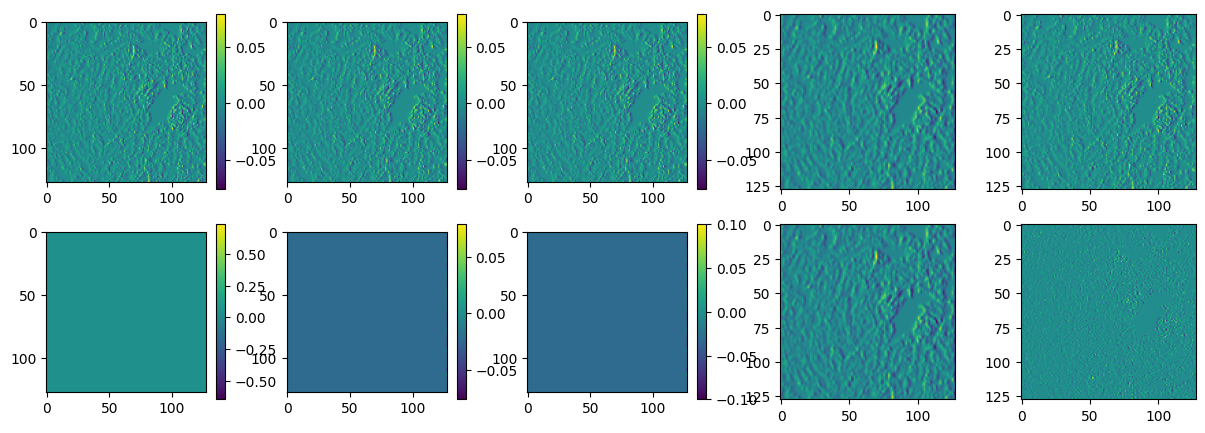

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
ax0 = ax[0,0].imshow(gradient_cil_arrays[0][2][8])
ax1 = ax[0,1].imshow(gradient_me_arrays[0][0][8])
ax2 = ax[0,2].imshow(jacobian_me_arrays[0][0][8])
ax3 = ax[0,3].imshow(gradient_pytorch_list[0][0][8])
ax4 = ax[0,4].imshow(gradient_cil_me_list[0][8,:,:,2])


# diff to cil
ax5 = ax[1,0].imshow(gradient_cil_arrays[0][2][8] - gradient_cil_arrays[0][2][8])
ax6 = ax[1,1].imshow(gradient_me_arrays[0][0][8] - gradient_cil_arrays[0][2][8])
ax7 = ax[1,2].imshow(jacobian_me_arrays[0][0][8] - gradient_cil_arrays[0][2][8])
ax8 = ax[1,3].imshow(gradient_pytorch_list[0][0][8] - gradient_cil_arrays[0][2][8])
ax9 = ax[1,4].imshow(gradient_cil_me_list[0][8,:,:,2] - gradient_cil_arrays[0][2][8])

# colorbars
fig.colorbar(ax0, ax=ax[0,0])
fig.colorbar(ax1, ax=ax[0,1])
fig.colorbar(ax2, ax=ax[0,2])
fig.colorbar(ax3, ax=ax[1,0])
fig.colorbar(ax4, ax=ax[1,1])
fig.colorbar(ax5, ax=ax[1,2])

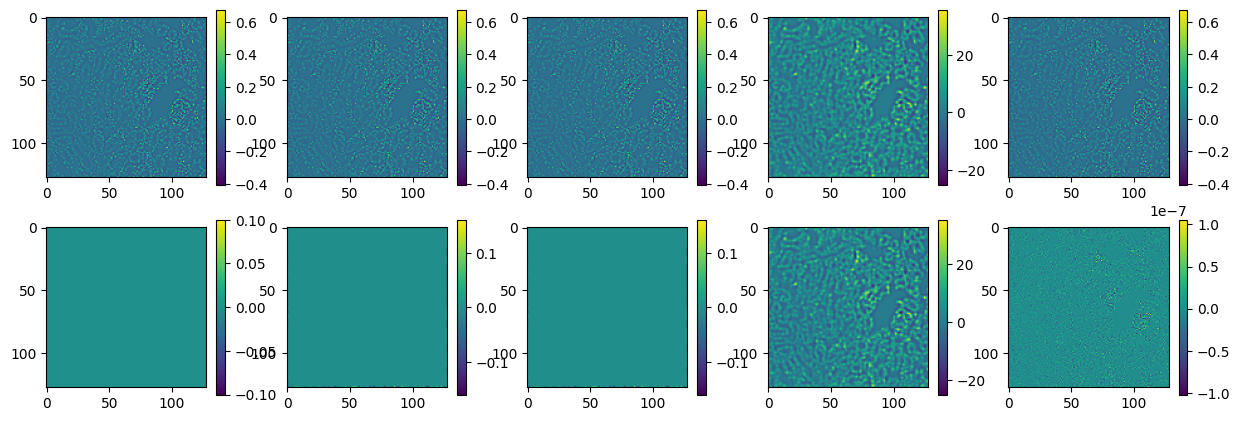

In [9]:
fig, ax = plt.subplots(2,5, figsize=(15,5))
ax0 = ax[0,0].imshow(reverse_gradient_cil_list[0].as_array()[8])
ax1 = ax[0,1].imshow(reverse_gradient_me_list[0][8])
ax2 = ax[0,2].imshow(reverse_jacobian_me[8,:,:,0])
ax3 = ax[0,3].imshow(reverse_gradient_pytorch_list[0][8])
ax4 = ax[0,4].imshow(reverse_gradient_cil_me_list[0][8])

# diff to cil
ax5 = ax[1,0].imshow(reverse_gradient_cil_list[0].as_array()[8] - reverse_gradient_cil_list[0].as_array()[8])
ax6 = ax[1,1].imshow(reverse_gradient_me_list[0][8] - reverse_gradient_cil_list[0].as_array()[8])
ax7 = ax[1,2].imshow(reverse_jacobian_me[8,:,:,0] - reverse_gradient_cil_list[0].as_array()[8])
ax8 = ax[1,3].imshow(reverse_gradient_pytorch_list[0][8] - reverse_gradient_cil_list[0].as_array()[8])
ax9 = ax[1,4].imshow(reverse_gradient_cil_me_list[0][8] - reverse_gradient_cil_list[0].as_array()[8])

#colorbars
fig.colorbar(ax0, ax=ax[0,0])
fig.colorbar(ax1, ax=ax[0,1])
fig.colorbar(ax2, ax=ax[0,2])
fig.colorbar(ax3, ax=ax[0,3])
fig.colorbar(ax4, ax=ax[0,4])
fig.colorbar(ax5, ax=ax[1,0])
fig.colorbar(ax6, ax=ax[1,1])
fig.colorbar(ax7, ax=ax[1,2])
fig.colorbar(ax8, ax=ax[1,3])
fig.colorbar(ax9, ax=ax[1,4])



In [10]:
jg = JointGradient(3,3)

In [11]:
l2norm0 = L2NormSquared(b = arr0_noise)
l2norm1 = L2NormSquared(b = arr1_noise)
l2norm2 = L2NormSquared(b = arr2_noise)

l2norm = BlockFunction([l2norm0, l2norm1, l2norm2])

kl0 = KullbackLeibler(b = arr0_noise)
kl1 = KullbackLeibler(b = arr1_noise)
kl2 = KullbackLeibler(b = arr2_noise)

kl = BlockFunction([kl0, kl1, kl2])

mapem0 = MAPEM(lam = arr0_noise, s = np.ones_like(arr0))
mapem1 = MAPEM(lam = arr1_noise, s = np.ones_like(arr1))
mapem2 = MAPEM(lam = arr2_noise, s = np.ones_like(arr2))

mapem = BlockFunction([mapem0, mapem1, mapem2])

tnv = 400 * VectorialTotalVariation()

In [12]:
tv = L21Norm()
tv_bf = BlockFunction([L21Norm(), L21Norm(), L21Norm()])

grad = Gradient()

grad_bo = BlockOperator([grad]*3)

quad = QuadraticPrior()
quad_bf = BlockFunction([1*QuadraticPrior()]*3)
id_bo = BlockOperator([IdentityOperator()]*3)

grad = Gradient()
sl21 = SmoothedL21Norm(10e-8)
sl21_ocf_grad = OperatorCompositionFunction(sl21, grad)
sl21_ocf_grad_bf = BlockFunction([sl21_ocf_grad,]*3)

sl21_ocf_jg = OperatorCompositionFunction(sl21, jg)

In [13]:
f = SumFunction([kl,sl21_ocf_grad_bf])
f2 = SumFunction([kl,quad_bf])
f4 = SumFunction([kl,sl21_ocf_jg])

In [14]:
gd = GradientDescent(arr_noise, f4, step_size=10, max_iterations=1000, update_interval=50)

In [15]:
#gd.run()

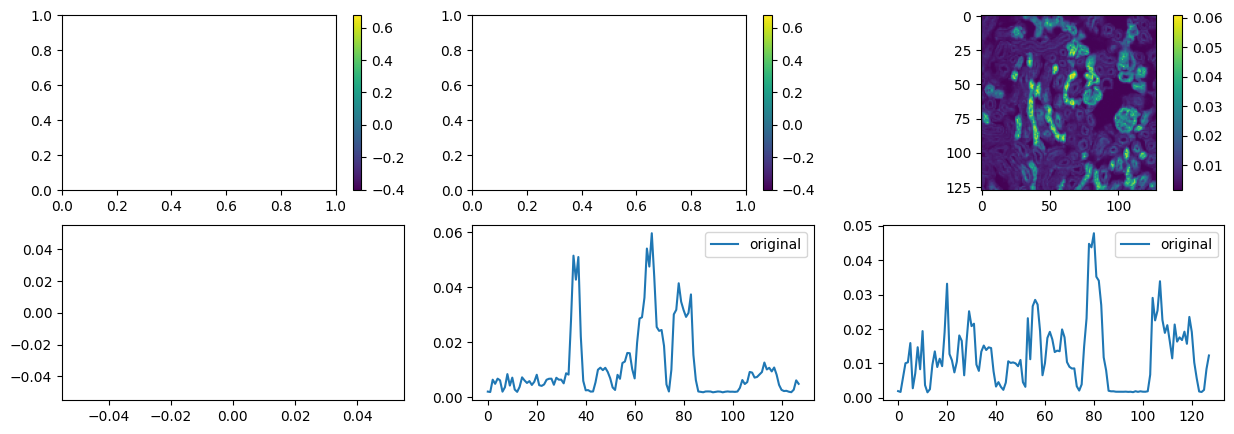

In [16]:
fig, ax  = plt.subplots(2, 3 , figsize=(15, 5))
#ax0 = ax[0,0].imshow(gd.solution[8,:,:,0])
#ax1 = ax[0,1].imshow(gd.solution[8,:,:,1])
ax2 = ax[0,2].imshow(arr_noise[8,:,:,1])

# colorbar
fig.colorbar(ax0, ax=ax[0,0])
fig.colorbar(ax1, ax=ax[0,1])
fig.colorbar(ax2, ax=ax[0,2])

ax[1,0].plot(gd.objective)
# log scale
#ax[1,0].set_yscale('log')
#ax[1,0].set_xscale('log')

#ax[1,1].plot(gd.x[8,64,:,1], label='x')
ax[1,1].plot(arr_noise[8,64,:,1], label='original')
ax[1,1].legend()

#ax[1,2].plot(gd.solution[8,64,:,2], label='y')
ax[1,2].plot(arr_noise[8,64,:,2], label='original')
ax[1,2].legend()



In [17]:
lbfgsb = LBFGSB()
initial = arr_noise
lbfgsb.set_up(initial, f4, max_iterations=100) 

In [18]:
lbfgsb.run()

2215.072825733324
2173.4109485399226
1889.422980424612
1731.4321126478494
1656.4634975967747
1541.096269919515
1488.325556630316
1453.8876855679214
1413.177941449436
1383.5569160302427
1357.3398740688297
1338.8180170647677
1317.2889709038911
1302.2739366695607
1285.7340399691866
1271.054421268996
1259.1504205112228
1249.7947944819848
1242.1089591766668
1235.5471050568076
1231.3783041293564
1227.433874259337
1223.8763000759543
1220.9697346783541
1218.7749808850408
1217.0005519436065
1215.419268235507
1214.3583119494688
1213.2219316451808
1212.5973133515547
1212.2999315328395
1210.9489814075
1210.190276155122
1209.7928110934117
1209.5849635121558
1209.420572493629
1209.3366899727012
1208.982128750619
1208.5160119670074
1208.2037722555801
1208.1062825427114
1208.0813968816235
1208.0628446866672
1208.0221270310553
1207.9803859494837
1207.9604982991673
1207.9593204511948
1207.9590097133678
1207.9580454296133
1207.9565989025446
1207.9560382191398
1207.9557780972918
1207.9557112591704
1207.95

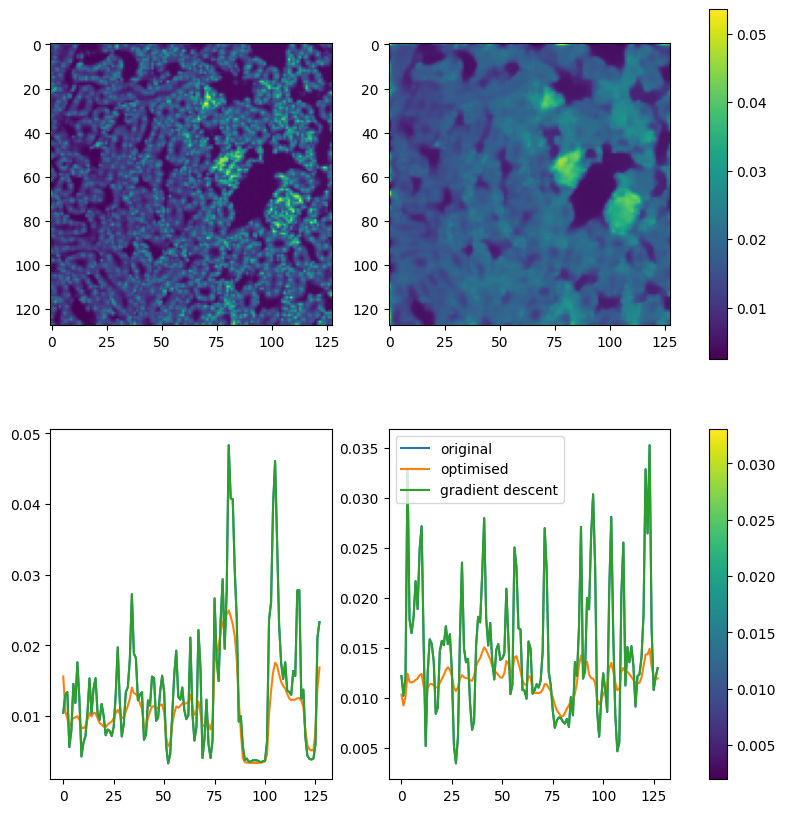

In [19]:
fig, ax  = plt.subplots(2, 2, figsize=(10, 10))
im0 = ax[0,0].imshow(arr_noise[8,:,:,0])
im1 = ax[0,1].imshow(lbfgsb.solution[8,:,:,0])
ax[1,0].plot(arr_noise[8,60,:,0])
ax[1,0].plot(lbfgsb.solution[8,60,:,0])
ax[1,0].plot(gd.solution[8,60,:,0])
ax[1,1].plot(arr_noise[8,:,60,0])
ax[1,1].plot(lbfgsb.solution[8,:,60,0])
ax[1,1].plot(gd.solution[8,:,60,0])

# colorbar
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

ax[1,1].legend(['original', 'optimised', 'gradient descent'])


In [20]:
indic = Indicator(0)
#jac_norm = power_iteration(jac_me, arr.shape)
#grad_norm = power_iteration(grad_me, arr0.shape)
#jgrad_norm = power_iteration(jg, arr.shape)

jac_norm=  74.26310731905657
grad_norm=  74.2593395312066
jgrad_norm=  11.879948955484757

In [21]:
print("jac_norm: ", jac_norm)
print("grad_norm: ", grad_norm)
print("jgrad_norm: ", jgrad_norm)

jac_norm:  74.26310731905657
grad_norm:  74.2593395312066
jgrad_norm:  11.879948955484757


In [22]:
tau = 1 / jac_norm
sigma = 1 /jac_norm

In [23]:
pdhg = PDHG()
pdhg.set_up(arr_noise, kl, tnv, jac_me, tau, sigma, 
            rho=0.99, max_iterations=5000, save_interval=100,
            adaptivity=0, adapt_interval=10)

In [26]:
pdhg.run(verbose=1)

iteration: 429
Objectives: [1494607.3365142036, 0, 173.21764691555677, 1494434.118867288]
step size increased, self.sigma = 0.049798595973200445, self.tau = 0.019178702657998533
step size increased, self.sigma = 0.0505595641385651, self.tau = 0.019657057053534384
step size increased, self.sigma = 0.05132681135331895, self.tau = 0.02014944228502651
step size increased, self.sigma = 0.05210073527607126, self.tau = 0.020656129964375488
step size increased, self.sigma = 0.05288171250498908, self.tau = 0.0211774075330138
step size increased, self.sigma = 0.053670100508573036, self.tau = 0.021713577916282967
step size increased, self.sigma = 0.05446623938042338, self.tau = 0.022264959255642185
step size increased, self.sigma = 0.05527045342992926, self.tau = 0.022831884711769394
iteration: 500
Objectives: [1405968.1918601035, 0, 203.99965958947644, 1405764.192200514]
step size increased, self.sigma = 0.05608305269415894, self.tau = 0.023414702301850304
step size increased, self.sigma = 0.056

SystemError: CPUDispatcher(<function svd at 0x7f380a7b91b0>) returned a result with an exception set

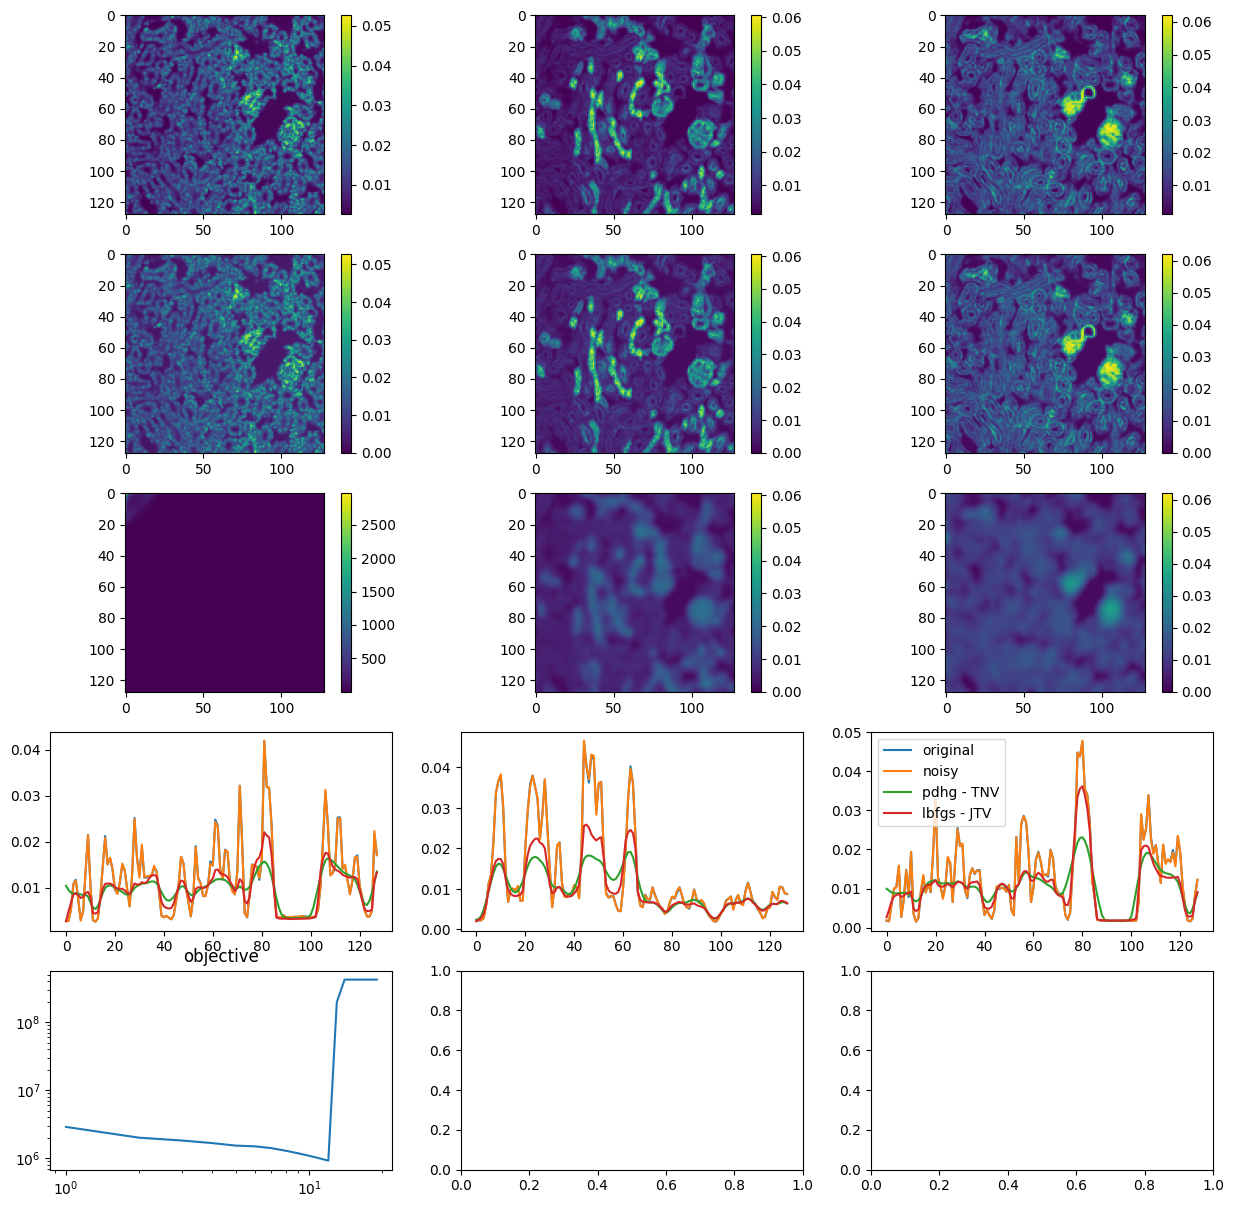

In [31]:
fig, ax = plt.subplots(5,3, figsize=(15,15))
a1 = ax[0,0].imshow(arr_resized[8,:,:,0])
vmax0 = np.max(arr_resized[8,:,:,0])
a2 = ax[0,1].imshow(arr_resized[8,:,:,1])
vmax1 = np.max(arr_resized[8,:,:,1])
a3 = ax[0,2].imshow(arr_resized[8,:,:,2])
vmax2 = np.max(arr_resized[8,:,:,2])
a4 = ax[1,0].imshow(arr_noise[8,:,:,0], vmin = 0, vmax = vmax0)
a5 = ax[1,1].imshow(arr_noise[8,:,:,1], vmin = 0, vmax = vmax1)
a6 = ax[1,2].imshow(arr_noise[8,:,:,2], vmin = 0, vmax = vmax2)
a7 = ax[2,0].imshow(pdhg.solution[8,:,:,0], vmin = 0, vmax = vmax0)
a8 = ax[2,1].imshow(pdhg.solution[8,:,:,1], vmin = 0, vmax = vmax1)
a9 = ax[2,2].imshow(pdhg.solution[8,:,:,2], vmin = 0, vmax = vmax2)

ax[3,0].plot(arr_resized[8,64,:,0])
ax[3,0].plot(arr_noise[8,64,:,0])
ax[3,0].plot(pdhg.solution[8,64,:,0])
ax[3,0].plot(lbfgsb.solution[8,64,:,0])

ax[3,1].plot(arr_resized[8,:,64,1])
ax[3,1].plot(arr_noise[8,:,64,1])
ax[3,1].plot(pdhg.solution[8,:,64,1])
ax[3,1].plot(lbfgsb.solution[8,:,64,1])

ax[3,2].plot(arr_resized[8,64,:,2], label='original')
ax[3,2].plot(arr_noise[8,64,:,2], label='noisy')
ax[3,2].plot(pdhg.solution[8,64,:,2], label='pdhg - TNV')
ax[3,2].plot(lbfgs.solution[8,64,:,2], label='lbfgs - JTV')

ax[3,2].legend()

# plot objective over entire bottom row
x = np.arange(1,len(pdhg.objective)+1)
ax[4,0].plot(x,pdhg.objective)
ax[4,0].set_title('objective')
# log scale
ax[4,0].set_yscale('log')
ax[4,0].set_xscale('log')

# colorbar
fig.colorbar(a1, ax=ax[0,0])
fig.colorbar(a2, ax=ax[0,1])
fig.colorbar(a3, ax=ax[0,2])
fig.colorbar(a4, ax=ax[1,0])
fig.colorbar(a5, ax=ax[1,1])
fig.colorbar(a6, ax=ax[1,2])
fig.colorbar(a7, ax=ax[2,0])
fig.colorbar(a8, ax=ax[2,1])
fig.colorbar(a9, ax=ax[2,2])



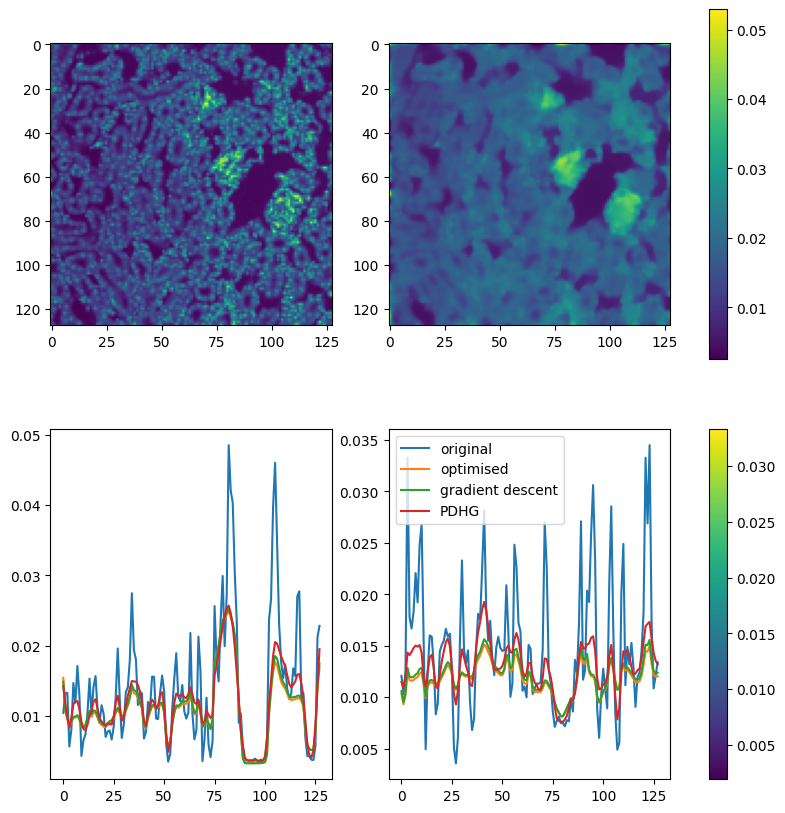

In [ ]:
fig, ax  = plt.subplots(2, 2, figsize=(10, 10))
im0 = ax[0,0].imshow(arr_noise[8,:,:,0])
im1 = ax[0,1].imshow(lbfgsb.solution[8,:,:,0])
ax[1,0].plot(arr_noise[8,60,:,0])
ax[1,0].plot(lbfgsb.solution[8,60,:,0])
ax[1,0].plot(gd.solution[8,60,:,0])
ax[1,0].plot(pdhg.solution[8,60,:,0])

ax[1,1].plot(arr_noise[8,:,60,0])
ax[1,1].plot(lbfgsb.solution[8,:,60,0])
ax[1,1].plot(gd.solution[8,:,60,0])
ax[1,1].plot(pdhg.solution[8,:,60,0])

# colorbar
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

ax[1,1].legend(['original', 'optimised', 'gradient descent', 'PDHG'])

In [ ]:
sigma =  0.1 / l2norm.L
tau = sigma / jac_norm**2

In [ ]:
pd3o = PD3O()
pd3o.set_up(np.ones_like(arr_resized)*0.1, l2norm, indic, tv, jg, tau, sigma, rho=0.99, max_iterations=100, save_interval=1)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
pd3o.run(verbose=1)

iteration: 74
Objectives: [2217.090427516422, 0.0008328998512571858, 0.0, 2217.089594616571]
iteration: 75
Objectives: [2217.252084714672, 0.0006784705314437376, 0.0, 2217.2514062441405]
iteration: 76
Objectives: [2217.4030365961767, 0.0005532396565986113, 0.0, 2217.40248335652]
iteration: 77
Objectives: [2217.5443408790325, 0.00045171032002364736, 0.0, 2217.543889168712]
iteration: 78
Objectives: [2217.6769510370978, 0.00036942039506295465, 0.0, 2217.6765816167026]
iteration: 79
Objectives: [2217.8017265298677, 0.0003027477704324646, 0.0, 2217.801423782097]
iteration: 80
Objectives: [2217.9194420368112, 0.0002487522414252924, 0.0, 2217.9191932845697]
iteration: 81
Objectives: [2218.0307957914442, 0.0002050471583212728, 0.0, 2218.0305907442857]
iteration: 82
Objectives: [2218.136417101566, 0.00016969523165321983, 0.0, 2218.1362474063344]
iteration: 83
Objectives: [2218.236873134152, 0.00014112394796378928, 0.0, 2218.2367320102044]
iteration: 84
Objectives: [2218.332675036006, 0.0001180

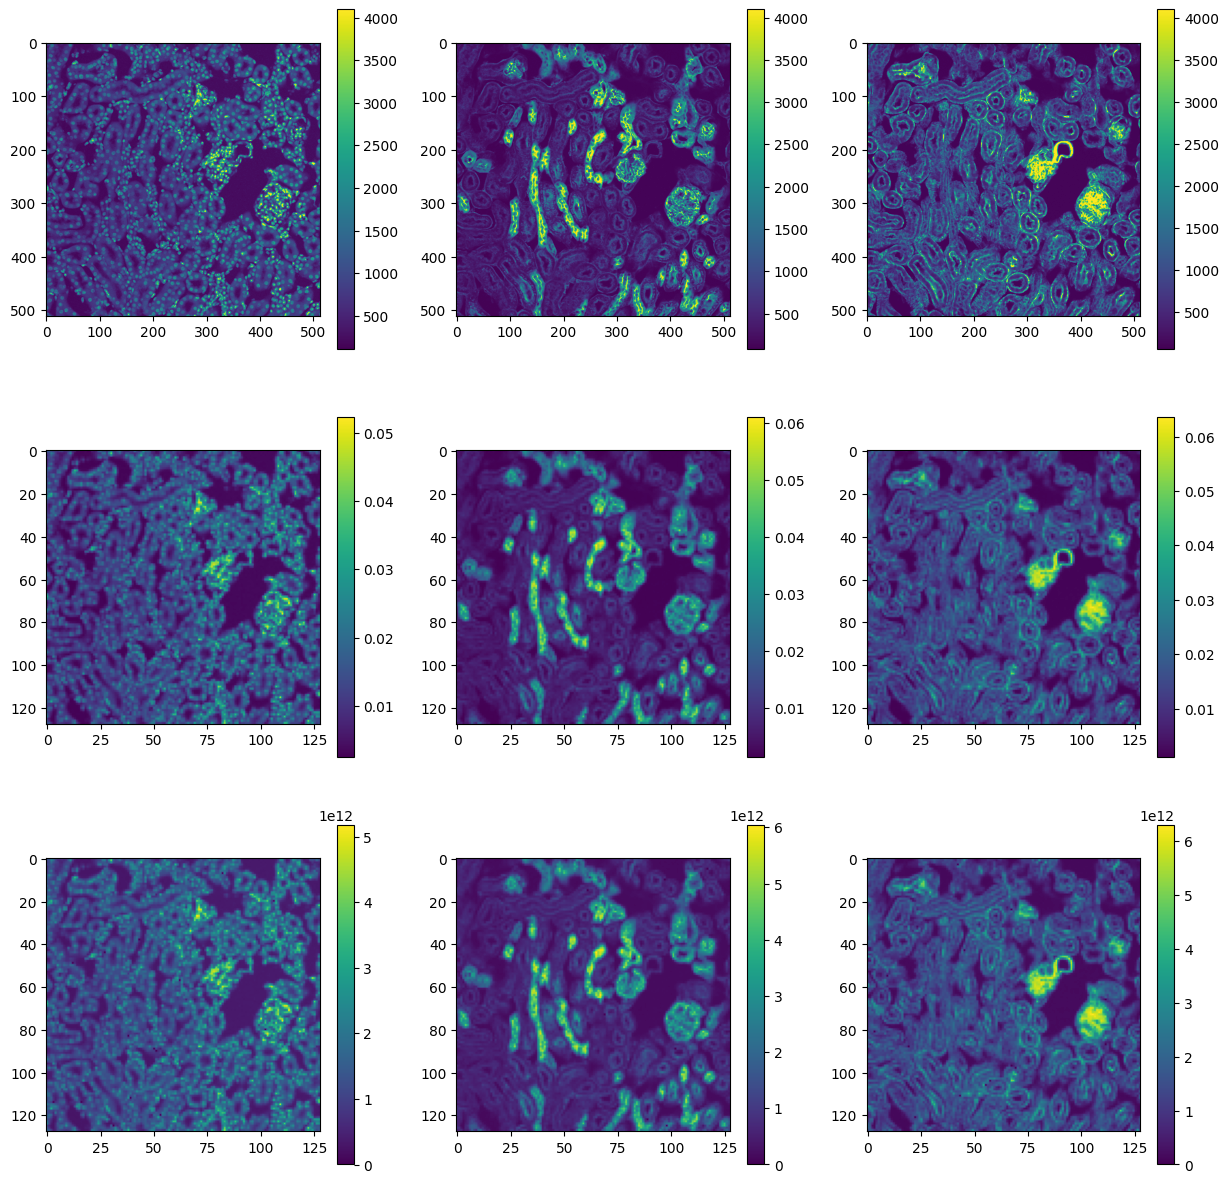

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
ax[0,0].imshow(arr[8,:,:,0])
ax[0,1].imshow(arr[8,:,:,1])
ax[0,2].imshow(arr[8,:,:,2])
ax[1,0].imshow(arr_noise[8,:,:,0])
ax[1,1].imshow(arr_noise[8,:,:,1])
ax[1,2].imshow(arr_noise[8,:,:,2])
ax[2,0].imshow(pd3o.solution[8,:,:,0])
ax[2,1].imshow(pd3o.solution[8,:,:,1])
ax[2,2].imshow(pd3o.solution[8,:,:,2])

# colorbars
fig.colorbar(ax[0,0].imshow(arr[8,:,:,0]), ax=ax[0,0])
fig.colorbar(ax[0,1].imshow(arr[8,:,:,1]), ax=ax[0,1])
fig.colorbar(ax[0,2].imshow(arr[8,:,:,2]), ax=ax[0,2])
fig.colorbar(ax[1,0].imshow(arr_noise[8,:,:,0]), ax=ax[1,0])
fig.colorbar(ax[1,1].imshow(arr_noise[8,:,:,1]), ax=ax[1,1])
fig.colorbar(ax[1,2].imshow(arr_noise[8,:,:,2]), ax=ax[1,2])
fig.colorbar(ax[2,0].imshow(pd3o.solution[8,:,:,0]), ax=ax[2,0])
fig.colorbar(ax[2,1].imshow(pd3o.solution[8,:,:,1]), ax=ax[2,1])
fig.colorbar(ax[2,2].imshow(pd3o.solution[8,:,:,2]), ax=ax[2,2])
